In [ ]:
!pwd

In [ ]:
!ls

## Detector:

In [10]:
import sys
import cv2

sys.path.insert(0, '/home/tesla/tigers_bbox/final_detector/Detector/yolov5')
import Detector

det = Detector.YoloDetector(weights='./best1.pt', img_size=480, conf_thres=0.4, iou_thres=0.4)

def detector_process_file(image_file):
    
    try:
        img = cv2.imread(image_file)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    except Exception:
        print("err with : " + image_file)
        return []
        
    bboxes = det.detect(img_rgb)
    for box in bboxes:
        box[box < 0] = 0
        
    return bboxes


In [11]:
from PIL import Image
from urllib.request import Request, urlopen
import cv2
from collections import OrderedDict
import numpy as np
import sys
import antialiased_cnns
import torch
import torchvision
from torchvision import transforms, models
import cv2
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt

import pickle

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def get_embedding(model, x):
    x = model.conv1(x)
    x = model.bn1(x)
    x = model.relu(x)
    x = model.maxpool(x)

    x = model.layer1(x)
    x = model.layer2(x)
    x = model.layer3(x)
    x = model.layer4(x)

    x = model.avgpool(x)
    x = x.view(x.size(0), -1)
    emb = x
    x = model.fc(x)
    return x, emb


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

model_path = '/home/tesla/tigers_bbox/trained_models/resnet152/weights_epoch_63.h5'
model = antialiased_cnns.resnet152(pretrained=True).to(device)
model.fc = torch.nn.Sequential(
       torch.nn.Linear(2048, 128),
       torch.nn.ReLU(inplace=True),
       torch.nn.Linear(128, 2)).to(device)
model.load_state_dict(torch.load(model_path))
model.eval()
for param in model.parameters():
    param.requires_grad = False
model._modules.get('avgpool')
with open('/home/tesla/tg_bot/telegram_tiger_bot/predictor_152.pickle', 'rb') as handle: ##predictor.pickle
    predictor_knn = pickle.load(handle)

    
    
def predict_princess(box, img_orig):
    if box[5] == 1:
        img_cropped = img_orig[int(box[1]):int(box[3]), int(box[0]):int(box[2])]
        PILIm = Image.fromarray(img_cropped)
        transformed_img = transform(PILIm)
        transformed_img = torch.from_numpy(
                    np.expand_dims(transformed_img.numpy(),
                                   axis=0)
                                   ).float().cuda()
        _, emb_inf = get_embedding(model, transformed_img)
        res = predictor_knn.predict(emb_inf.cpu())
        return res[0]
    else:
        return 0

# Что делаем?

1. собираем фото в отдельный каталог, проверяем - jpg или jpeg

2. задаём каталог FILES_PATH

3. запускаем, на выходе labels.csv

4. есть простая проверка CSV

In [12]:
import glob, os
from tqdm import tqdm

preds = []

# check if jpg of jpeg

#FILES_PATH = "/home/tesla/tigers_bbox/data/Test_300/3classes/tigers/*.jpg"
FILES_PATH = "/home/tesla/PrincessVsNotPrincess/*.jpg"


for py in tqdm(glob.glob(FILES_PATH)):
    
    result = detector_process_file(py)
    
    img_orig = cv2.imread(py)
    
    result_class = 0
    
    for box in result:
        if predict_princess(box, img_orig) == 1:
            result_class = 1
            break
    
# class – класс объекта:
# 1 – Принцесса
# 0 – Не Принцесса
    
    
    preds.append("\n" + os.path.basename(py) + ',' + str(result_class))
    #print(py)
    

with open('labels1.csv', 'w') as out:
    out.write("id,class")
    out.writelines(preds)

    


100%|██████████| 283/283 [01:27<00:00,  3.25it/s]


In [14]:
########################
### check
#######################


import pandas as pd

# class – класс объекта:
# 1 – Принцесса
# 0 – Не Принцесса

labels = pd.read_csv('labels1.csv')

labels['class'].value_counts()

0    214
1     69
Name: class, dtype: int64

Populating the interactive namespace from numpy and matplotlib
002_1553.jpg


/home/tesla/env/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


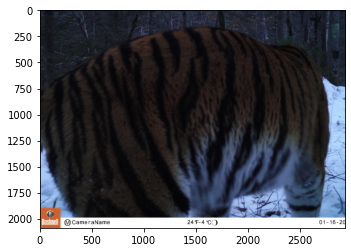

002_1273.jpg


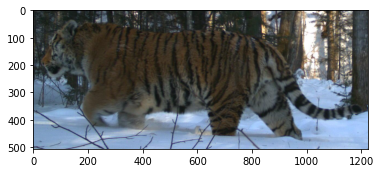

002_678.jpg


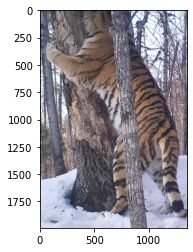

003_525.jpg


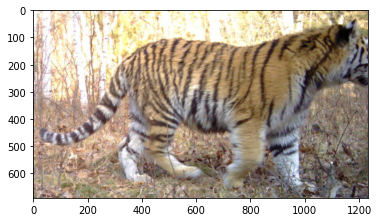

002_923.jpg


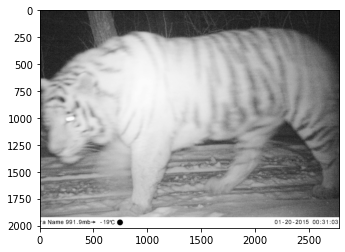

002_1645.jpg


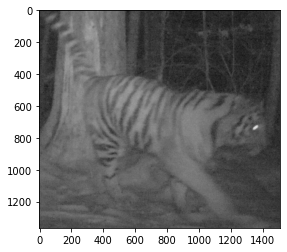

001_1135.jpg


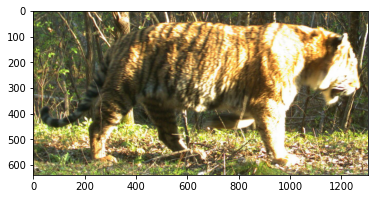

001_313.jpg


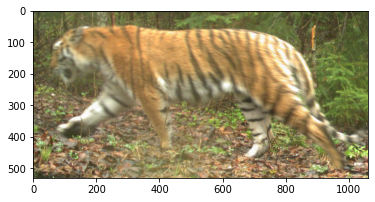

001_1302.jpg


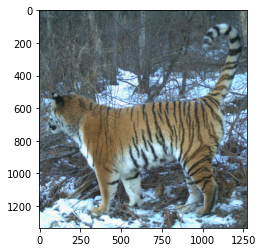

002_1371.jpg


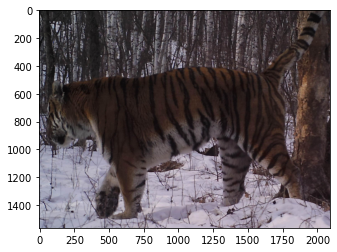

002_1108.jpg


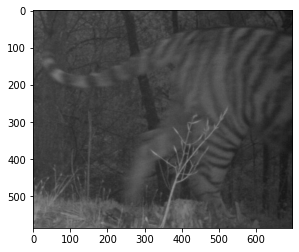

003_140.jpg


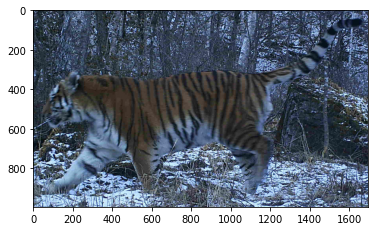

002_1557.jpg


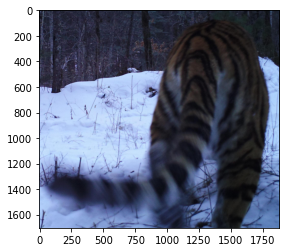

002_1556.jpg


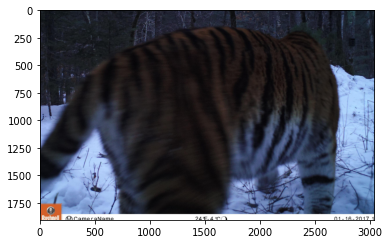

001_516.jpg


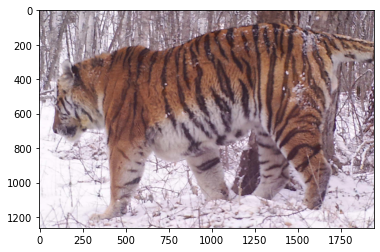

002_1434.jpg


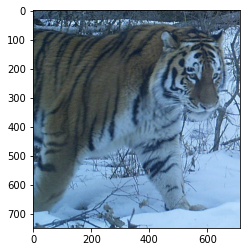

003_548.jpg


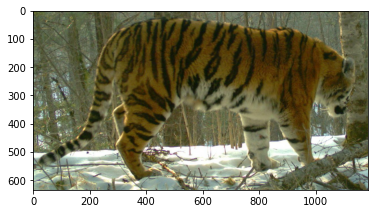

002_981.jpg


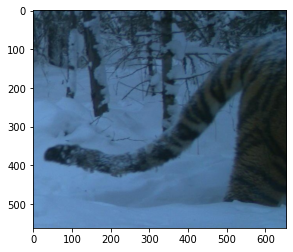

In [9]:
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

empty_files = labels[labels['class'] == 1]['id']

for f in empty_files:
    print(f)
    img = mpimg.imread('/home/tesla/PrincessVsNotPrincess/'+f)
    imgplot = plt.imshow(img)
    plt.show()

In [15]:
labels2 = pd.read_csv('labels2.csv')



0    235
1     48
Name: class, dtype: int64

In [16]:
labels['class'].value_counts()

0    214
1     69
Name: class, dtype: int64

In [17]:
labels2['class'].value_counts()

0    235
1     48
Name: class, dtype: int64

In [19]:
l1 = list(labels['class'])
l2 = list(labels2['class'])

In [21]:
#Merge classes from two predictors
l3 = []

for i in range(len(l1)):
    l3.append(l1[i] | l2[i])

In [23]:
sum(l3)

89

In [24]:
labels['class'] = l3

In [28]:
labels.to_csv('princess.csv', index=False)